# HMM State Clustering
In this notebook we'll explore a post-hoc method for clustering HMM states.
The idea is, given an HMM which has been fit to data, we reduce the number of states hierarchically by merging pairs of states. Let's say we start with an HMM with K states. The idea is that we'll try merging every pair of states and see which merge makes the log-likelihood of the data go down the least. Once we find that pair, we have K-1 states, and we repeat this process until we have satisfactorily few states.

**Note**: This notebook is a little rough around the edges.

In [25]:
import os
import pickle
import joblib
import time

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

from sklearn.utils import check_array, check_random_state

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import hmmlearn
from hmmlearn import hmm
from hmmlearn import _utils
from hmmlearn.utils import normalize

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# Cluster states from the original HMM

The `merge_two_states` function below takes in a trained HMM, and indices of two states, s1 and s2. It outputs a new HMM where all states except for s1 and s2 are the same, along with the log-likelihood of the data under the new model.

Here's how we merge two states: In the E-step of the EM algorithm, we obtain a T x K table, which has the probability of being in state K at time T for every time point. To merge state k1 and k2, we take the two columns of the table corresponding to these two states and sum them. From this, we get a new table which is K-1 x T. We then run an M-step as normal to get the best parameters for our new K-1 state model, and evaluate the log likelihood.

**NOTE**: as written, the below function does not support inputs or masks, and it is limited to HMMs with stationary transitions. 

In [26]:
filename = '/Users/Caravaggio/Downloads/m1_fr0.1hz_30hz_0s_7200s_0.1s_bins_nooverlap.sav'

with open(filename, 'rb') as file:
    spike_times_all_neurons = joblib.load(file)

# Convert to numpy array
spike_times_all_neurons = np.array(spike_times_all_neurons)

# Transpose into (71999, 90)
spike_times_all_neurons = spike_times_all_neurons.T

# Truncate two hour recording to 10 minutes into (6000, 90), 
# 0th to 45th L5/6, 46th to 89th L2/3, 89th being the most shallow
spike_times_all_neurons = spike_times_all_neurons[:6000]

# Z-score each neuron, i.e. firing rates of each neuron across time sum to 0
spike_times_all_neurons_zscored = stats.zscore(spike_times_all_neurons) # Default axis is 0

data = spike_times_all_neurons_zscored
print(f'Spike times are binned into shape for hmm: {data.shape}')

Spike times are binned into shape for hmm: (6000, 90)


In [27]:
# Set the parameters
num_states = 20   # number of discrete states

# hmmlearn_hmm
hmm_test = hmmlearn.hmm.GaussianHMM(n_components=num_states, covariance_type="full", n_iter=100, verbose=False)
t_start = time.time()
hmm_test.fit(data)
t_end = time.time()
print(f'{t_end - t_start} seconds taken to fit a 20-state hmm model using hmmlearn.')

20.036427974700928 seconds taken to fit a 20-state hmm model using hmmlearn.


In [28]:
def merge_two_states(hmm_old, s1, s2, data, observations="gaussian"):
    assert s1 < s2
    
    def collapse_and_sum_1d(arr, i, j):
        out = arr.copy()
        out[i] += out[j]
        return np.delete(out, j)
    
    def collapse_and_sum_2d(arr, i, j, axis=0):
        assert axis <= 1
        out = arr.copy()
        if axis == 0:
            out[i,:] += out[j,:]
            return np.delete(out, j, axis=0)
        if axis == 1:
            out[:, i] += out[:, j]
            return np.delete(out, j, axis=1)
    
    data = check_array(data)
    hmm_old._check()
   
    start_prob = hmm_old.startprob_
    start_prob_new = collapse_and_sum_1d(start_prob, s1, s2)
    
    transmtx = hmm_old.transmat_
    transmtx_new = collapse_and_sum_2d(transmtx, s1, s2, axis=1)
    transmtx_new = collapse_and_sum_2d(transmtx_new, s1, s2, axis=0)
    
    K = hmm_old.n_components
    hmm_new = hmm.GaussianHMM(n_components=K-1, covariance_type="full", verbose=True)
    hmm_new._init(data)
    hmm_new._check()
    stats = hmm_new._initialize_sufficient_statistics()
    stats['start'] = start_prob_new
    stats['trans'] = transmtx_new
    
    lattice, log_prob, posteriors, fwdlattice, bwdlattice = \
                    hmm_old._fit_log(data)
    posteriors_new = collapse_and_sum_2d(posteriors, s1, s2, axis=1)
    post_new = posteriors_new.sum(axis=0)
    stats['post'] = post_new
    stats['obs'] = np.dot(posteriors_new.T, data)
    stats['obs*obs.T'] += np.einsum(
                    'ij,ik,il->jkl', posteriors_new, data, data) 
    hmm_new._do_mstep(stats)
    ll_new = hmm_new.score(data)
    
    return ll_new, hmm_new

In [ ]:
# merge two states using hmmlearn
hmm_old = hmm_test
ll_old = hmm_old.score(data)
print('previous log-likelihood is ' + str(ll_old))
ll_new, hmm_new = merge_two_states(hmm_test, 0, 3, data)
print('current log-likelihood is ' + str(ll_new))
print("likelihood drop: ", ll_old - ll_new)

## Make a pairwise similarity matrix

We can use the log-likelihood drop when merging states as a proxy for state "similarity." Two states which can be merged with minimal drop in likelihood might be considered similar.

In [29]:
def make_similarity_matrix(hmm_original, data):
    num_states = hmm_original.n_components
    init_ll = hmm_original.score(data)
    similarity = np.nan * np.ones((num_states, num_states))
    merged_hmms = np.empty((num_states, num_states), dtype=object)
    for s1 in range(num_states-1):
        for s2 in range(s1+1, num_states):
            merged_ll, merged_hmm = merge_two_states(hmm_original, s1, s2, data)
            similarity[s1, s2] =  merged_ll - init_ll
            merged_hmms[s1, s2] = merged_hmm
        print(f'Finished state {s1}')
            
    return similarity, merged_hmms

Finished state 0
Finished state 1
Finished state 2
Finished state 3
Finished state 4
Finished state 5
Finished state 6
Finished state 7
Finished state 8
Finished state 9
Finished state 10
Finished state 11
Finished state 12
Finished state 13
Finished state 14
Finished state 15
Finished state 16
Finished state 17
Finished state 18
445.49808502197266 seconds taken to make a similarity matrix for a 15-state hmm.


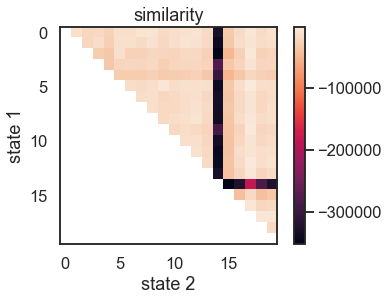

In [35]:
t_start = time.time()
similarity, new_hmms = make_similarity_matrix(hmm_test, data)
t_end = time.time()
print(f'{t_end - t_start} seconds taken to make a similarity matrix for a 15-state hmm.')
im = plt.imshow(similarity)
plt.ylabel("state 1")
plt.xlabel("state 2")
plt.title("similarity")
plt.colorbar()

## Hierarchical clustering by iteratively merging states
We start with a K state HMM, then merge possible pair of states k1 and k2. We can see which are the best two states to merge by checking the new log-likelihood. We then rinse and repeat for our new K-1 state HMM, tracking the log-likelihood as we go, until there is only 1 state left. After each merge, we can show the observation distribution and new similarity matrix.

In [30]:
def hierarchical_cluster(hmm_original, data, p=1):
    num_states = hmm_original.n_components
    assert p <= num_states
    assert p >= 1
    merge_times = num_states - p
    
    linkage = [None]
    likelihood_drops = [0]
    hmms = [hmm_original]
    
    for i in range(merge_times):
        similarity, merged_hmms = make_similarity_matrix(hmms[-1], data)
        
        # Find the most similar states
        s1, s2 = np.where(similarity == np.nanmax(similarity))
        s1, s2 = s1[0], s2[0]
        linkage.append((s1, s2))
        likelihood_drops.append(similarity[s1, s2])
        hmms.append(merged_hmms[s1, s2])
        print("merging ", s1, "and", s2)
    
    return linkage, likelihood_drops, hmms

In [31]:
linkage, likelihood_drops, hmms = hierarchical_cluster(hmm_test, data, p=1)

Finished state 0
Finished state 1
Finished state 2
Finished state 3
Finished state 4
Finished state 5
Finished state 6
Finished state 7
Finished state 8
Finished state 9
Finished state 10
Finished state 11
Finished state 12
Finished state 13
Finished state 14
Finished state 15
Finished state 16
Finished state 17
Finished state 18
merging  5 and 17
Finished state 0
Finished state 1
Finished state 2
Finished state 3
Finished state 4
Finished state 5
Finished state 6
Finished state 7
Finished state 8
Finished state 9
Finished state 10
Finished state 11
Finished state 12
Finished state 13
Finished state 14
Finished state 15
Finished state 16
Finished state 17
merging  0 and 12
Finished state 0
Finished state 1
Finished state 2
Finished state 3
Finished state 4
Finished state 5
Finished state 6
Finished state 7
Finished state 8
Finished state 9
Finished state 10
Finished state 11
Finished state 12
Finished state 13
Finished state 14
Finished state 15
Finished state 16
merging  0 and 8
Finis

## Now plot the dendrogram using likelihood drop as similarity

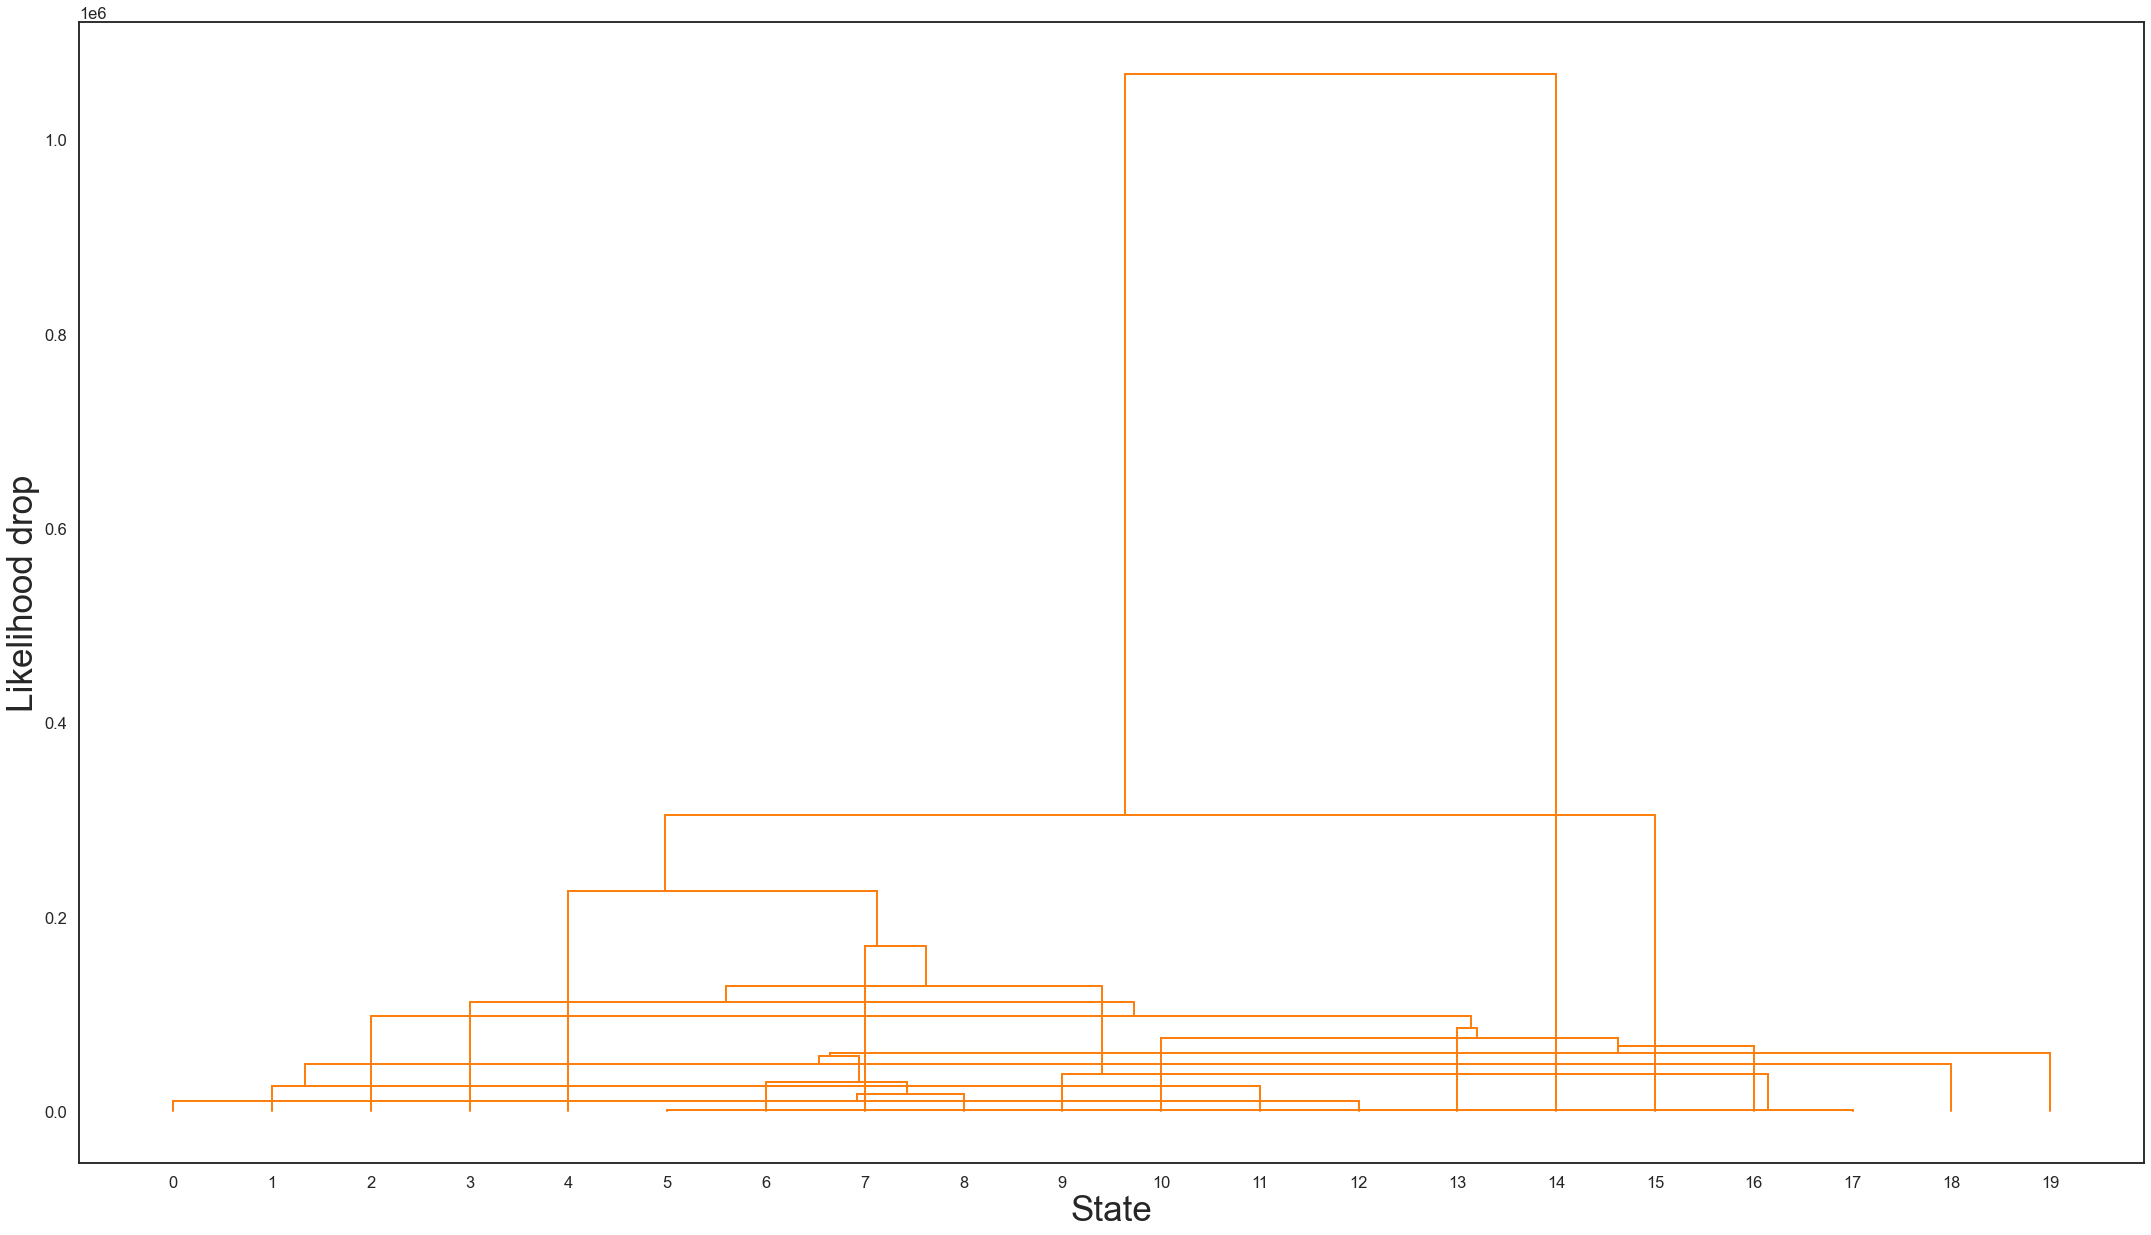

In [34]:
def dendrogram(num_states, linkage, likelihood_drops):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(37, 21)
    
    def _plot_level(s1, s2, likelihood_drop, xs, offset):
        new_offset = offset - likelihood_drop
        for x in xs:
            plt.plot([x, x], [offset, new_offset], '-', color='#ff7f0e', lw=2)
            plt.plot([xs[s1], xs[s2]], [new_offset, new_offset], '-', color='#ff7f0e', lw=2)

        new_xs = xs.copy()
        new_xs[s1] = xs[s1] + (xs[s2] - xs[s1]) * npr.rand()
        new_xs = np.concatenate([new_xs[:s2], new_xs[s2+1:]])
        return new_xs, new_offset
    
    xs = np.arange(num_states, dtype=float)
    offset = 0
    
    for (s1, s2), drop in zip(linkage[1:], likelihood_drops[1:]):
        xs, offset = _plot_level(s1, s2, drop, xs, offset)
        
    plt.xlabel("State", fontsize=35)
    plt.xticks(np.arange(num_states, dtype=float))
    plt.ylabel("Likelihood drop", fontsize=35)
        
dendrogram(hmm_test.n_components, linkage, likelihood_drops)

save_plot = True
if save_plot == True:
    plt.savefig('hmm_20_states_hierarchical_clustering.png', dpi=300, bbox_inches = "tight")